# Best Model Selection

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

In [1]:
import pandas as pd
import numpy as np
import warnings
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

random = 42
warnings.filterwarnings("ignore")

## Data preparation

In [2]:
df = pd.read_csv('/datasets/car_data.csv', parse_dates=['DateCrawled','DateCreated','LastSeen'], nrows=5000)

df.columns = ['date', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'created', 'pictures', 'postal','last_seen']

In [3]:
print(df.head(3))
print("------------------------------------------------------------------------------")
print('Present of missing values:')
print(round(100*df.isnull().sum()[df.isnull().sum()>0]/len(df),2))
print("------------------------------------------------------------------------------")
print(df.nunique())
print("------------------------------------------------------------------------------")
print(df.info())

                 date  price vehicle_type  registration_year gearbox  power  \
0 2016-03-24 11:52:00    480          NaN               1993  manual      0   
1 2016-03-24 10:58:00  18300        coupe               2011  manual    190   
2 2016-03-14 12:52:00   9800          suv               2004    auto    163   

   model  mileage  registration_month fuel_type       brand not_repaired  \
0   golf   150000                   0    petrol  volkswagen          NaN   
1    NaN   125000                   5  gasoline        audi          yes   
2  grand   125000                   8  gasoline        jeep          NaN   

     created  pictures  postal           last_seen  
0 2016-03-24         0   70435 2016-07-04 03:16:00  
1 2016-03-24         0   66954 2016-07-04 01:46:00  
2 2016-03-14         0   90480 2016-05-04 12:47:00  
------------------------------------------------------------------------------
Present of missing values:
vehicle_type    11.74
gearbox          5.80
model           

array([[<AxesSubplot:title={'center':'date'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'registration_year'}>],
       [<AxesSubplot:title={'center':'power'}>,
        <AxesSubplot:title={'center':'mileage'}>,
        <AxesSubplot:title={'center':'registration_month'}>],
       [<AxesSubplot:title={'center':'created'}>,
        <AxesSubplot:title={'center':'pictures'}>,
        <AxesSubplot:title={'center':'postal'}>],
       [<AxesSubplot:title={'center':'last_seen'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

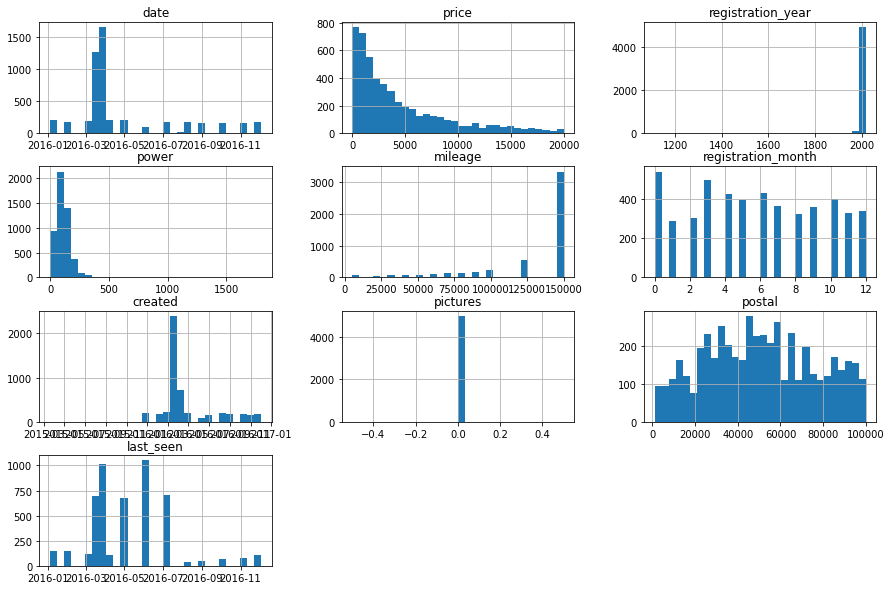

In [4]:
df.hist(bins=30, figsize=(15, 10))

### Study Features:
- 'date' , 'created' and 'last_seen' are irrelevant features for price prediction.
- 'pictures' is 0 in all rows, can be discarded.
- other features looking fine.

### Select relevant features, and define catagorical features list:

In [5]:
irrelevant_features = ['date', 'created', 'last_seen', 'pictures']
cat_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand','not_repaired']

original_df = df.copy()
df = df.drop(irrelevant_features, axis=1)

In [6]:
df.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,postal
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480


### OrdinalEncode all catagorical data in dataset:

In [7]:
encode_df = df.copy()
encoder = OrdinalEncoder()

def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    nonulls = np.array(data.dropna())
    impute_reshape = nonulls.reshape(-1,1)
    impute_ordinal = encoder.fit_transform(impute_reshape)
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data 


for columns in cat_cols:
    encode_df[columns]  = encode(encode_df[columns])

In [8]:
encode_df.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,postal
0,480,NaN,1993,1.0,0,102.0,150000,0,6.0,38.0,NaN,70435
1,18300,2.0,2011,1.0,190,NaN,125000,5,2.0,1.0,1.0,66954
2,9800,6.0,2004,0.0,163,103.0,125000,8,2.0,14.0,NaN,90480


### Split the source data into a training set, a validation set, and a test set:


In [9]:
impute_data = encode_df.copy()

df_train, df_valid = train_test_split(impute_data, test_size=0.3, random_state = random)

features_train = df_train.drop(['price'], axis=1)
target_train = df_train['price']

features_valid = df_valid.drop(['price'], axis=1)
target_valid = df_valid['price']

### KNNImput missing values in dataset than OneHotEncoder them:

In [10]:
imputer = KNNImputer()
features_train = pd.DataFrame(np.round(imputer.fit_transform(features_train)),columns = features_train.columns)
features_valid = pd.DataFrame(np.round(imputer.transform(features_valid)),columns = features_valid.columns)

In [11]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

array_hot_encoded = ohe.fit_transform(features_train[cat_cols])
data_hot_encoded = pd.DataFrame(array_hot_encoded, columns = ohe.get_feature_names(cat_cols))
data_other_cols = features_train.drop(columns=cat_cols)
features_train_hot = pd.concat([data_hot_encoded, data_other_cols], axis=1)

array_hot_encoded = ohe.transform(features_valid[cat_cols])
data_hot_encoded = pd.DataFrame(array_hot_encoded, columns = ohe.get_feature_names(cat_cols))
data_other_cols = features_valid.drop(columns=cat_cols)
features_valid_hot = pd.concat([data_hot_encoded, data_other_cols], axis=1)


## Model training
### DecisionTreeRegressor optimization:


In [12]:
%%time
model = DecisionTreeRegressor()
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = random)

# search space
dt_grid = dict()
dt_grid['criterion'] = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
dt_grid['splitter'] = ['best', 'random']
dt_grid['max_features'] = ['auto', 'sqrt', None, 'log2']
dt_grid['min_samples_split'] = [2, 5, 10, 15 ]
dt_grid['min_samples_leaf'] = [1, 5, 12, 16 ,20, 30]

search = GridSearchCV(model, dt_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv)
t0= time.time()

result = search.fit(features_train_hot, target_train)
t1= time.time()

yhat = result.predict(features_valid_hot)
t2= time.time()

dtree_params = result.best_params_
dtree_model = result.best_estimator_

dtree_op_RMSE = mean_squared_error(target_valid, yhat)**0.5
dtree_op_score = {'rmse': [dtree_op_RMSE], 'training_time': [t1 - t0 ],'prediction_time': [t2 - t1 ]}
dtree_op_score = pd.DataFrame(dtree_op_score, index = [ 'DecisionTreeRegressorOptim' ])

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -2548.1338495062623
Best Hyperparameters: {'criterion': 'friedman_mse', 'max_features': 'auto', 'min_samples_leaf': 16, 'min_samples_split': 5, 'splitter': 'best'}
CPU times: user 8min 58s, sys: 1.39 s, total: 8min 59s
Wall time: 8min 59s


### RandomForestRegressor optimization:

In [23]:
%%time
from sklearn.model_selection import RandomizedSearchCV

model = RandomForestRegressor()

rforest_grid = dict()
rforest_grid['n_estimators'] = list(range(50, 500, 50))
rforest_grid['criterion'] = ['squared_error', 'absolute_error', 'poisson']
rforest_grid['max_depth'] = list(range(10, 110, 10))
rforest_grid['min_samples_split'] = [2, 5, 10, 20, 30, 40]
rforest_grid['min_samples_leaf'] = [1, 2, 7, 12, 14, 16 ,20, 30]
rforest_grid['max_features'] = ['auto', 'sqrt', None, 'log2']
rforest_grid['bootstrap'] = [True, False]


rf_random = RandomizedSearchCV(estimator = model,
                               scoring='neg_root_mean_squared_error',
                               param_distributions = rforest_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state = random, 
                               n_jobs = -1)

t0= time.time()
result = rf_random.fit(features_train_hot,target_train)

t1= time.time()
yhat = result.predict(features_valid_hot)

t2= time.time()
rforest_params = result.best_params_
rforest_model = result.best_estimator_

rforest_op_RMSE = mean_squared_error(target_valid, yhat)**0.5
rforest_op_score = {'rmse': [rforest_op_RMSE], 'training_time': [t1 - t0 ],'prediction_time': [t2 - t1 ]}
rforest_op_score = pd.DataFrame(rforest_op_score, index = [ 'RandomForestRegressorOptim' ])

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, criterion=squared_error, max_depth=100, max_features=auto, min_samples_leaf=14, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, criterion=squared_error, max_depth=100, max_features=auto, min_samples_leaf=14, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, criterion=squared_error, max_depth=100, max_features=auto, min_samples_leaf=14, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, criterion=squared_error, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=40, n_estimators=300; total time=   0.1s
[CV] END bootstrap=True, criterion=squared_error, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=40, n_estimators=300; total time=   0.1s
[CV] END bootstrap=True, criterion=squared_error, max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=

### CatBoost:

In [25]:
cat_train, cat_valid = train_test_split(df.dropna(), test_size=0.3, random_state = random)

cat_features_train = cat_train.drop(['price'], axis=1)
cat_target_train = cat_train['price']

cat_features_valid = cat_valid.drop(['price'], axis=1)
cat_target_valid = cat_valid['price']

In [26]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(loss_function="RMSE", iterations=50)
t0= time.time()

model.fit(cat_features_train, cat_target_train, cat_features = cat_cols, verbose=10) 
t1= time.time()

pred_cat = model.predict(cat_features_valid) 
t2= time.time()

cat_RMSE = mean_squared_error(cat_target_valid, pred_cat)**0.5
cat_score = {'rmse': [cat_RMSE], 'training_time': [t1 - t0 ],'prediction_time': [t2 - t1 ]}
cat_score = pd.DataFrame(cat_score, index = [ 'CatBoostRegressor' ])

Learning rate set to 0.5
0:	learn: 3504.4338251	total: 2.35ms	remaining: 115ms
10:	learn: 1943.7266166	total: 19.9ms	remaining: 70.7ms
20:	learn: 1711.0812548	total: 36.6ms	remaining: 50.5ms
30:	learn: 1571.1787182	total: 54.1ms	remaining: 33.1ms
40:	learn: 1480.5514476	total: 71.8ms	remaining: 15.8ms
49:	learn: 1398.9767245	total: 86.2ms	remaining: 0us


### LightGBM:

In [27]:
gbm_df = df.copy()
#gbm_df = gbm_df.drop(['date', 'created', 'last_seen'], axis=1)

for feature in cat_cols:
    gbm_df[feature] = pd.Series(gbm_df[feature], dtype="category")
    
gbm_train, gbm_valid = train_test_split(gbm_df, test_size=0.3, random_state = random)

gbm_features_train = gbm_train.drop(['price'], axis=1)
gbm_target_train = gbm_train['price']

gbm_features_valid = gbm_valid.drop(['price'], axis=1)
gbm_target_valid = gbm_valid['price']

In [28]:
import lightgbm as lgb
t0= time.time()

# create dataset for lightgbm
lgb_train = lgb.Dataset(gbm_features_train, gbm_target_train)
lgb_eval = lgb.Dataset(gbm_features_valid, gbm_target_valid, reference=lgb_train)

# specify configuration
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                categorical_feature = cat_cols,
                num_boost_round=20,
                valid_sets = lgb_eval,
                callbacks = [lgb.early_stopping(stopping_rounds=5)])

t1= time.time()
y_pred = gbm.predict(gbm_features_valid, num_iteration = gbm.best_iteration)
t2= time.time()

lgbm_RMSE = mean_squared_error(gbm_target_valid, y_pred)**0.5
lgbm_score = {'rmse': [lgbm_RMSE], 'training_time': [t1 - t0 ],'prediction_time': [t2 - t1 ]}
lgbm_score = pd.DataFrame(lgbm_score, index = [ 'LightGBM' ])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 2039.48	valid_0's l2: 7.70375e+06


### XGBoost:

In [29]:
import xgboost as xgb
model = xgb.XGBRegressor()
t0= time.time()

model.fit(features_train_hot,target_train)
t1= time.time()

yhat = model.predict(features_valid_hot)
t2= time.time()

xgboost_RMSE = mean_squared_error(target_valid, yhat)**0.5
xgboost_score = {'rmse': [xgboost_RMSE], 'training_time': [t1 - t0 ],'prediction_time': [t2 - t1 ]}
xgboost_score = pd.DataFrame(xgboost_score, index = [ 'XGBRegressor' ])

## Model analysis
### Create model evaluation function:

In [30]:
def model_evaluation( model, name = ""):
    t0= time.time()
    
    model.fit(features_train_hot,target_train)
    t1= time.time()

    predictions = model.predict(features_valid_hot)
    t2= time.time()

    RMSE = mean_squared_error(target_valid, predictions)**0.5
   
    score= {'rmse': [RMSE], 'training_time': [t1 - t0 ],'prediction_time': [t2 - t1 ]}  

    return pd.DataFrame(score, index = [str(model).split('(')[0] + name])

### Analyze the speed and quality of the models: 

In [31]:
model_score_ev = model_evaluation(LinearRegression())
model_score_ev = model_score_ev.append(model_evaluation(DecisionTreeRegressor()))
model_score_ev = model_score_ev.append(model_evaluation(RandomForestRegressor()))
model_score_ev = model_score_ev.append(rforest_op_score)
model_score_ev = model_score_ev.append(dtree_op_score)
model_score_ev = model_score_ev.append(cat_score)
model_score_ev = model_score_ev.append(lgbm_score)
model_score_ev = model_score_ev.append(xgboost_score)

* The difference between models acuracy is small, but the difference in time is large (somtimes in a 10^3 scale), so to mitigate the scale difference I chose 90% and 10% as weights KPI.

In [32]:
model_score_ev['total_time'] = model_score_ev['training_time'] + model_score_ev['prediction_time']
model_score_ev['kpi'] = 0.9*model_score_ev['rmse']/model_score_ev.loc[['LinearRegression']].rmse.values + 0.1*model_score_ev['total_time']/model_score_ev.loc[['LinearRegression']].total_time.values

model_score_ev.sort_values(by = 'rmse').round(2)

,rmse,training_time,prediction_time,total_time,kpi
CatBoostRegressor,2048.36,0.37,0.00,0.38,0.43
XGBRegressor,2114.77,11.52,0.07,11.59,2.43
RandomForestRegressor,2203.23,3.17,0.05,3.22,0.96
DecisionTreeRegressorOptim,2480.63,539.78,0.00,539.79,96.04
RandomForestRegressorOptim,2765.45,343.23,0.15,343.38,61.31
LightGBM,2775.56,0.24,0.09,0.33,0.55
DecisionTreeRegressor,2996.32,0.14,0.01,0.15,0.55
LinearRegression,5110.72,0.37,0.20,0.56,1.00


## Conclusions:
* CatBoostRegressor is the most precise model for this dataset but it is also very slow.
* DecisionTreeRegressor is the fastest model for this dataset.
* Taking to account speed and precision CatBoostRegressor will be our best choice.